# Resample a DM influence function model to fit a given pupil sampling rate and actuator density

In [1]:
import numpy as np
import os

import poppy
import dms # modified gpipsfs DM module (https://github.com/geminiplanetimager/gpipsfs/blob/master/gpipsfs/dms.py)
import pdb

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['font.size'] = 12

import astropy.io

import scipy
import scipy.interpolate
import scipy.signal

print("Imported Poppy module from {0:s}".format(os.path.abspath(poppy.__file__)))

Imported Poppy module from /Users/ntz/WFIRST/poppy/poppy/__init__.py


In [2]:
scipy.__version__

'0.18.1'

In [3]:
os.environ['WEBBPSF_PATH'] = os.path.expanduser('~/WFIRST/webbpsf-data')
#os.environ['WEBBPSF_PATH'] = os.path.expanduser('~/STScI/WFIRST/webbpsf-data')

In [4]:
os.listdir(os.environ['WEBBPSF_PATH'])

['.README_DEVEL.txt.swp',
 'AFTA_CGI_C5_Pupil_onax_256px.fits',
 'AFTA_CGI_C5_Pupil_onax_256px_flip.fits',
 'AFTA_WFC_C5_Pupil_Mask_Norm_2048px.fits',
 'AFTA_WFC_C5_Pupil_Shortwave_Norm_2048px.fits',
 'CGI',
 'FGS',
 'IFC',
 'JWpupil_segments.fits',
 'jwst_pupil_RevW_npix1024.fits.gz',
 'jwst_pupil_RevW_npix16384.fits.gz',
 'jwst_pupil_RevW_npix2048.fits.gz',
 'MIRI',
 'NIRCam',
 'NIRISS',
 'NIRSpec',
 'README.txt',
 'si_zernikes_isim_cv3.fits',
 'tricontagon.fits.gz',
 'tricontagon_oversized_4pct.fits.gz',
 'upscaled_HST_OPD.fits',
 'version.txt',
 'wfc_pupil_masked_rev_mcr.fits',
 'wfc_pupil_rev_mcr.fits',
 'WFI',
 'WFIRSTMCRWFCPupilMaskNorm2048px.fits',
 'WFIRSTMCRWFCPupilShortwaveNorm2048px.fits']

## Set the number of actuators across the pupil and the pupil array diameter

In [24]:
Nact = 26
D = 256

## Load the influence function model

In [25]:
#dm_inf_func_hdulist = astropy.io.fits.open('/Users/ntz/WFIRST/SPC_gen3/WFC_model/influence_dm5v2.fits')
dm_inf_func_hdulist = astropy.io.fits.open('influence_dm5v2.fits')
dm_inf_func = dm_inf_func_hdulist[0].data[0,:,:] # 10 pixels actuator pitch
xc = dm_inf_func.shape[0] // 2
inf_func_pitch = 10 # pixels

## Set the downsampling factor

In [26]:
downsample_factor = (Nact*inf_func_pitch) / D
print('Downsampling factor = {}x'.format(downsample_factor))

Downsampling factor = 1.015625x


In [27]:
x_model = (np.arange(dm_inf_func.shape[1]) - xc)/downsample_factor
y_model = x_model
dm_inf_func_interp = scipy.interpolate.interp2d(x_model, y_model, dm_inf_func, kind='linear')
x_wf = np.arange(np.ceil(np.min(x_model)), np.floor(np.max(x_model))+1)
dm_inf_func_cgi = dm_inf_func_interp(x_wf, x_wf)

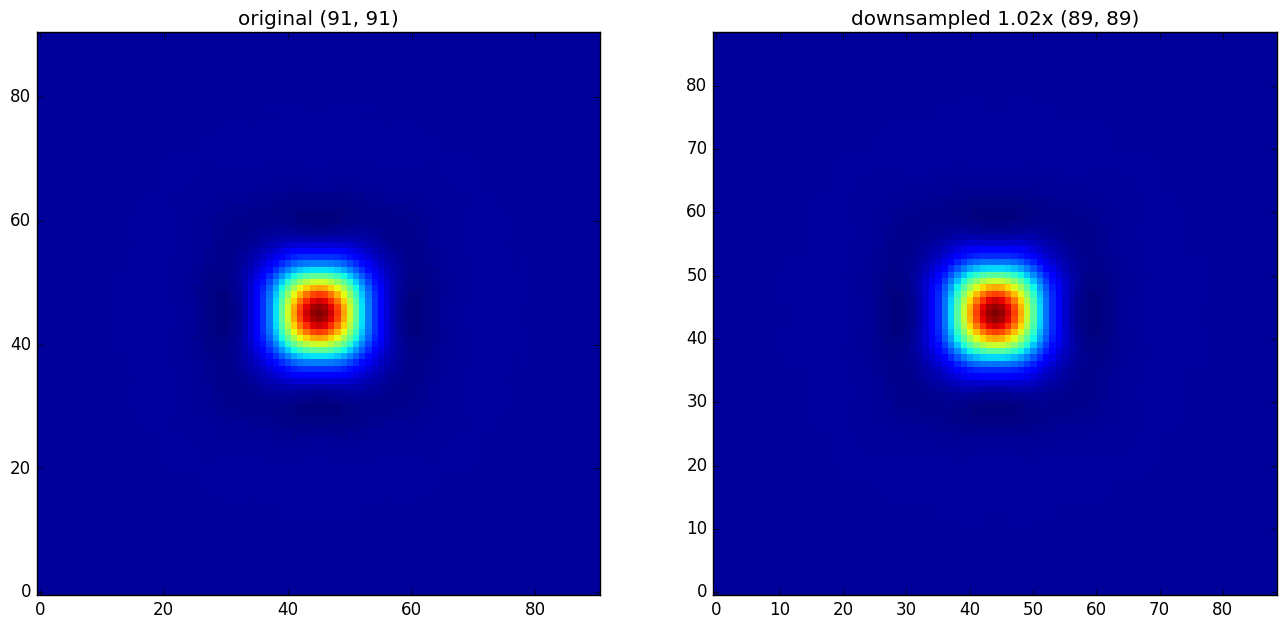

In [28]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(dm_inf_func)
plt.title('original {}'.format(dm_inf_func.shape))
plt.subplot(122)
plt.imshow(dm_inf_func_cgi)
plt.title('downsampled {:.2f}x {}'.format(downsample_factor, dm_inf_func_cgi.shape))

In [29]:
new_inf_func_fname = 'DM_influence_Nact{:d}_D{:d}.fits'.format(Nact, D)
dm_inf_func_cgi_hdu = astropy.io.fits.PrimaryHDU(dm_inf_func_cgi)
dm_inf_func_cgi_hdu.writeto(new_inf_func_fname, clobber=True)
print("Wrote new influence function to {}".format(new_inf_func_fname))

Wrote new influence function to DM_influence_Nact26_D256.fits


## Test PSF with sinusoid surface on DM

In [30]:
ovsamp=4
fov_arcsec = 2*0.82
wavelen = 770e-9

Tel_fname = os.path.join(os.environ['WEBBPSF_PATH'], "AFTA_CGI_C5_Pupil_onax_256px.fits")
DMinf_fname = new_inf_func_fname
#DMinf_fname = os.path.join(os.environ['WEBBPSF_PATH'], "CGI/OPD/CGI_DM_influence.fits")

X = np.ones((Nact,1)) * np.arange(Nact)
k = 6.
A = 50.

simpletel_1dm_optsys = poppy.OpticalSystem(oversample=ovsamp)

simpletel_1dm_optsys.addPupil(transmission=Tel_fname, name='tel pupil')

cgi_DM1 = dms.DeformableMirror(shape=(Nact,Nact), influence_func=DMinf_fname, name='DM1')
cgi_DM1.actuator_spacing = simpletel_1dm_optsys.planes[0].pupil_diam.value/(Nact-1) # telescope pupil-projected spacing in meters 
sinx_surface = A*np.sin(2*np.pi*k/Nact*X)
cgi_DM1.set_surface(sinx_surface, units='nm')

simpletel_1dm_optsys.addPupil(optic=cgi_DM1, name='DM1')

simpletel_1dm_optsys.addDetector(0.1, fov_arcsec=fov_arcsec)

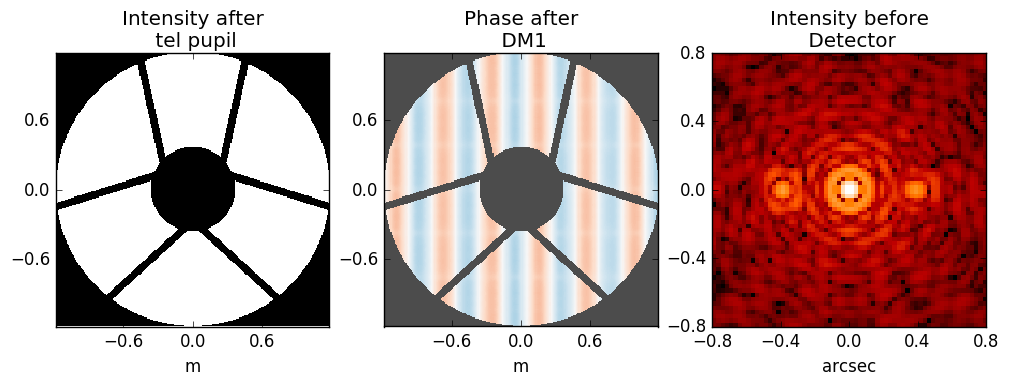

In [31]:
plt.figure(figsize=(12,5))
simpletel_1dm_psf, simpletel_1dm_interm_wfs = simpletel_1dm_optsys.calcPSF(wavelen, display_intermediates=True,
                                                                           return_intermediates=True)

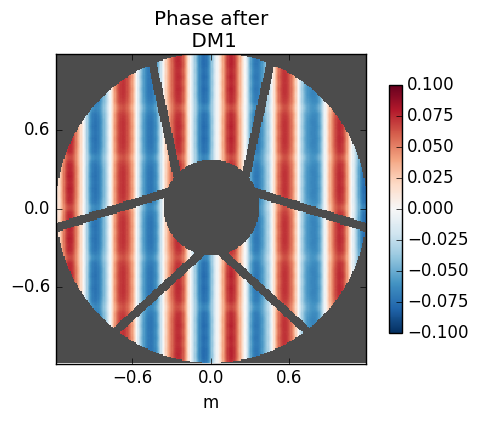

In [32]:
poppy.Wavefront.display(simpletel_1dm_interm_wfs[1], what='phase', colorbar=True, vmin=-0.1, vmax=0.1)

In [33]:
y, x = simpletel_1dm_interm_wfs[1].coordinates()
y_act, x_act = cgi_DM1.get_coordinates(one_d=True)

In [34]:
x_act.shape

(26,)

In [35]:
xwi_act = np.argmin( np.abs( x_act.reshape((Nact,1))*np.ones((1, x.shape[1])) - x[:Nact,:] ), axis=1 )

In [36]:
xwi_act

array([  0,  10,  20,  30,  40,  51,  61,  71,  81,  92, 102, 112, 122,
       133, 143, 153, 163, 174, 184, 194, 204, 215, 225, 235, 245, 255])

In [37]:
cgi_DM1.actuator_spacing

0.09480000000000001

In [38]:
# Set DM surface "picket fence" trace
act_trace_row = np.zeros((1,D), dtype='bool')
act_trace_row[0,xwi_act] = 1
act_trace = act_trace_row.T * act_trace_row
act_trace_flat = act_trace.ravel()
dm_command_flat = cgi_DM1.surface.ravel()
act_locs_flat = np.nonzero(act_trace_flat)
dm_trace_flat = np.zeros(act_trace_flat.shape)
dm_trace_flat[act_locs_flat] = dm_command_flat
dm_trace = dm_trace_flat.reshape((D,D))

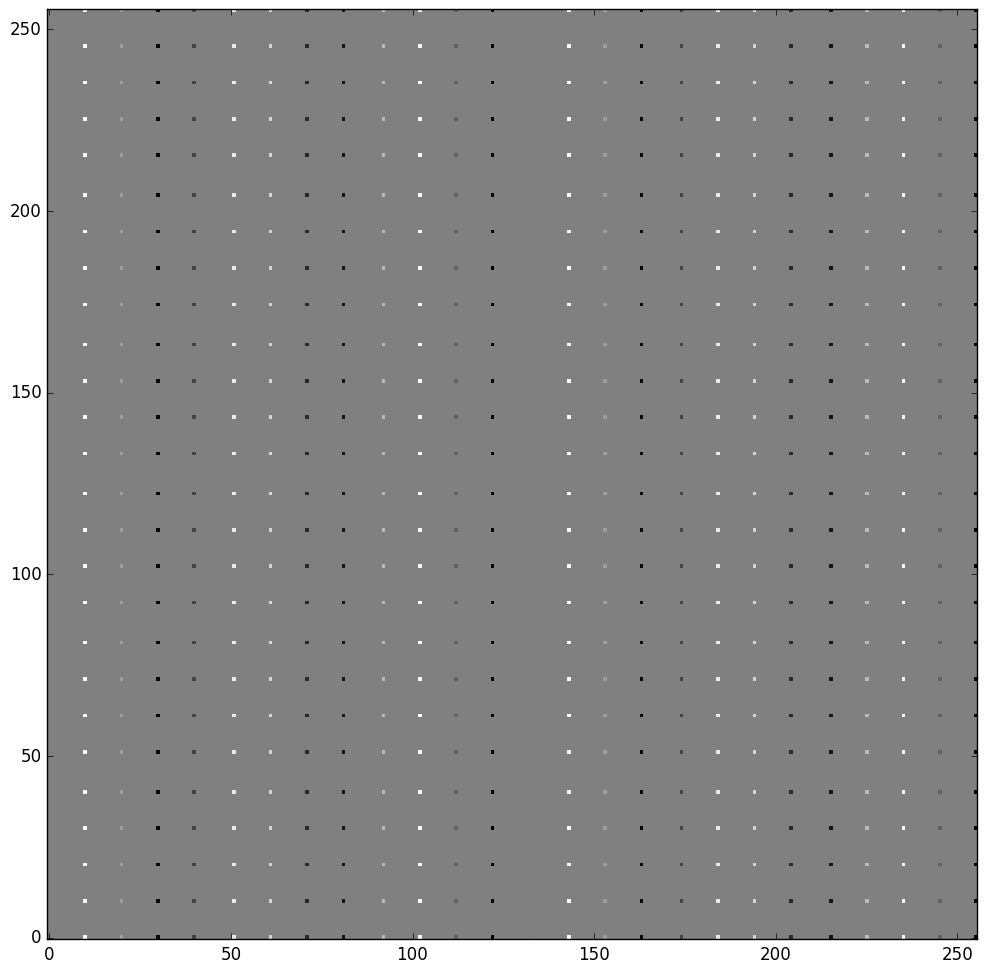

In [39]:
plt.figure(figsize=(12,12))
#plt.imshow(dm_trace[0:300,0:300], interpolation='nearest', cmap='gray')
plt.imshow(dm_trace, interpolation='nearest', cmap='gray')

In [40]:
dmsurf = scipy.signal.fftconvolve(dm_trace, dm_inf_func_cgi, mode='same')

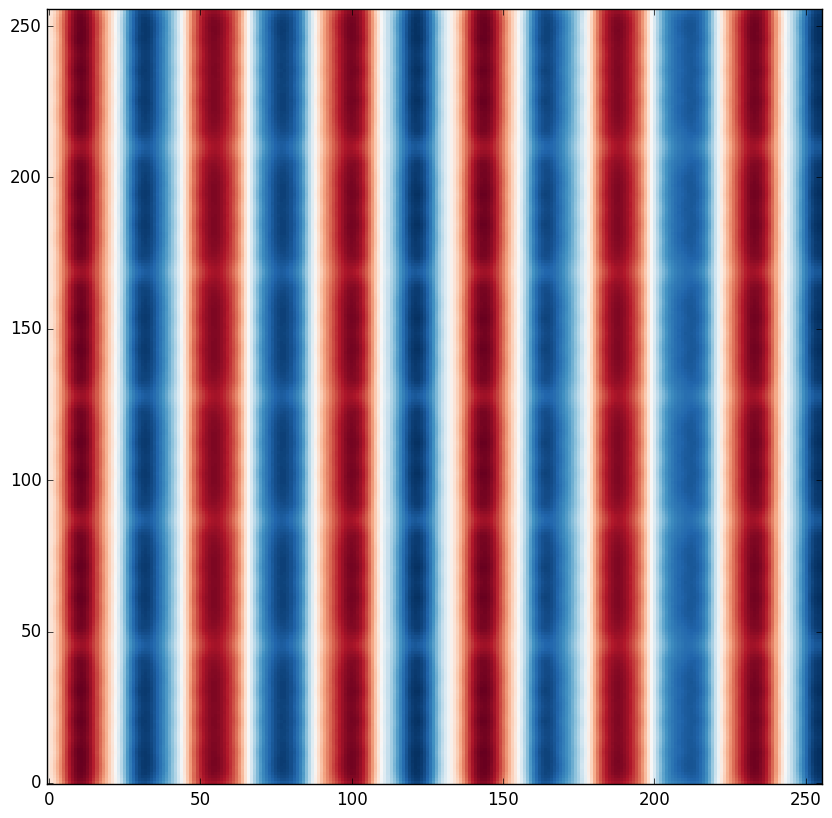

In [41]:
plt.figure(figsize=(10,10))
#plt.imshow(dmsurf[:300,:300], interpolation='nearest', cmap='gray')
plt.imshow(dmsurf, interpolation='nearest', cmap='RdBu_r')